## Training the positive-filtered drag model to capture the notion of total work

In the previous notebook (total_work_comparisons_filtered_drag_models), we answered the following question: How well do the two models currently predict real work? We found that the model trained only on negative drag forces captured real work surprisingly well (around 1% error), whereas the model trained for positive drag forces was a bit weaker (around 32% error). In this notebook, we will add a real work error term to the positive drag force DNN's loss function, with the hope that this will cause the total work prediction to improve. 

Questions:
- What happens when we bake the real work conservation requirement into our loss function for the positive drag force model? Will it improve the outcome in terms of real work and predicted work?
- If so, at what expense? How much will the mean absolute error rise if we put in this additional constraint?

### Import and prepare data

In [1]:
%pip install torch torchvision

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
import OpenMORe.OpenMORe.model_order_reduction as model_order_reduction
from OpenMORe.OpenMORe.utilities import *
import pandas as pd
from numpy import genfromtxt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import torch
import math

In [3]:
cu4_drag_force = genfromtxt('cu4_drag_force.csv', delimiter=',')

In [4]:
cu4_drag_force = pd.DataFrame(cu4_drag_force, columns=["x","eta","u","v","pressure","deta_dx","drag_force"])
cu4_drag_force

,x,eta,u,v,pressure,deta_dx,drag_force
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395
...,...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742,3.445307
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442,4.997804
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650,6.130174
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383,1.486284


In [5]:
cu4_pos_drag = cu4_drag_force.copy()

# apply filter for drag force
cu4_pos_drag[cu4_pos_drag['deta_dx'] < 0] = 0

### Calculation of real work

The integral of drag force over x is W (work). We can estimate this integral ourselves using the real data.

$W = \int F_{D}dx \approx \sum F_{d}(x_{i})\Delta x$

In [6]:
cu4_drag_force['dx'] = cu4_drag_force['x'].diff()

products = cu4_drag_force['dx'] * cu4_drag_force['drag_force']
real_work = np.sum(products)
real_work

355.83458649274985

### Define helper functions

In [7]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

### Training for positive drag model with no custom loss function

Positive drag model.

In [8]:
# Prepare the data
cu4_pos_drag = cu4_pos_drag.copy()[1:]

# Split the data into train and test
train_dataset_cu4_pos_drag = cu4_pos_drag.sample(frac=0.8, random_state=0)
test_dataset_cu4_pos_drag = cu4_pos_drag.drop(train_dataset_cu4_pos_drag.index)

train_dataset_cu4_pos_drag.pop('pressure')
test_dataset_cu4_pos_drag.pop('pressure')

train_dataset_cu4_pos_drag.pop('deta_dx')
test_dataset_cu4_pos_drag.pop('deta_dx')

print("shape of training dataset: ", train_dataset_cu4_pos_drag.shape)
print("shape of testing dataset: ", test_dataset_cu4_pos_drag.shape)

train_features_cu4_pos_drag = train_dataset_cu4_pos_drag.copy()
test_features_cu4_pos_drag = test_dataset_cu4_pos_drag.copy()

train_labels_cu4_pos_drag = train_features_cu4_pos_drag.pop('drag_force')
test_labels_cu4_pos_drag = test_features_cu4_pos_drag.pop('drag_force')

# Normalize the data
normalizer_cu4_pos_drag = tf.keras.layers.Normalization(axis=-1)
normalizer_cu4_pos_drag.adapt(np.array(train_features_cu4_pos_drag))

first = np.array(train_features_cu4_pos_drag[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer_cu4_pos_drag(first).numpy())

# Build the model
dnn_model_cu4_pos_drag = build_and_compile_model(normalizer_cu4_pos_drag)
dnn_model_cu4_pos_drag.summary()

shape of training dataset:  (8191, 5)
shape of testing dataset:  (2048, 5)


2022-11-16 20:11:32.842417: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


First example: [[0. 0. 0. 0.]]

Normalized: [[-0.16 -0.01  0.46  0.41]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [9]:
%%time
history_cu4_pos_drag = dnn_model_cu4_pos_drag.fit(
    train_features_cu4_pos_drag,
    train_labels_cu4_pos_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 38 s, sys: 6.75 s, total: 44.7 s
Wall time: 28.2 s


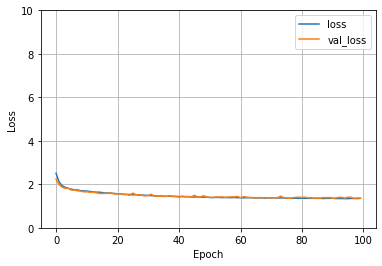

In [10]:
plot_loss(history_cu4_pos_drag)

### Evaluate the performance of positive drag model with no custom loss function

In [11]:
# Uncomment the following to inspect them

test_features_cu4_pos_drag = test_features_cu4_pos_drag[['x','eta','u','v']]
# test_dataset_cu4_pos_drag
#test_features_cu4_pos_drag
#test_labels_cu4_pos_drag

In [12]:
predicted_pos_drag_force = dnn_model_cu4_pos_drag.predict(test_features_cu4_pos_drag)

64/64 [==============================] - 0s 1ms/step


In [13]:
predicted_pos_drag_force.shape

(2048, 1)

In [14]:
print("average drag force: ", np.average(test_labels_cu4_pos_drag))
print("standard deviation of drag force: ", np.std(test_labels_cu4_pos_drag))

average drag force:  3.0289498011373026
standard deviation of drag force:  5.888705980783494


In [15]:
true_drag_force = cu4_drag_force[cu4_drag_force.index.isin(test_features_cu4_pos_drag.index)]['drag_force']

In [16]:
true_pos_drag_force = np.expand_dims(test_labels_cu4_pos_drag, axis=1)
true_pos_drag_force.shape

(2048, 1)

In [17]:
# mean absolute err for these predictions (can also compare against true_drag_force instead of true_pos_drag_force)
np.sum(np.abs(true_pos_drag_force - predicted_pos_drag_force)) / len(predicted_pos_drag_force) 

1.43561310070868

In [18]:
test_features_cu4_pos_drag['dx'] = test_features_cu4_pos_drag['x'].diff()

products = test_features_cu4_pos_drag['dx'] * np.squeeze(true_drag_force)
products
real_work = np.sum(products)
real_work

265.87685748857706

In [19]:
products = test_features_cu4_pos_drag['dx'] * np.squeeze(predicted_pos_drag_force)
predicted_work = np.sum(products)
predicted_work

199.43528860354124

In [20]:
np.abs((predicted_work - real_work) / real_work) * 100

24.989602146132768

With no custom loss function, we can see that the percent error of the total work prediction is about 32.9%, which is really high!

### Custom loss function

Now, we will define our custom loss function.

Note that dx is always the same value: 0.006763. We will hardcode this value in a variable to make our lives easier.

In [21]:
cu4_drag_force['dx'] = cu4_drag_force['x'].diff()
cu4_drag_force

,x,eta,u,v,pressure,deta_dx,drag_force,dx
0,-1.728670,1.594456,0.183840,0.726587,0.725233,NaN,NaN,NaN
1,-1.721907,1.592266,0.258540,0.806480,0.648305,-0.323798,-0.209920,0.006763
2,-1.715139,1.582960,0.269511,0.808270,0.614005,-1.375024,-0.844272,0.006768
3,-1.708376,1.568179,0.290845,0.924656,0.542222,-2.185638,-1.185102,0.006763
4,-1.701608,1.536428,0.301410,0.924826,0.508903,-4.691257,-2.387395,0.006768
...,...,...,...,...,...,...,...,...
10235,1.701608,1.513993,-1.130897,0.205433,1.193493,2.886742,3.445307,0.006768
10236,1.708376,1.543437,-1.123716,0.359496,1.148804,4.350442,4.997804,0.006768
10237,1.715139,1.580311,-1.125836,0.372134,1.124256,5.452650,6.130174,0.006763
10238,1.721907,1.589667,-1.117356,0.447627,1.075160,1.382383,1.486284,0.006768


In [22]:
dx = 0.006763

In [23]:
# input is tensors
def calculate_total_work(drag_force_predictions):
    product = tf.math.scalar_mul(dx, drag_force_predictions)
    my_sum = tf.math.reduce_sum(product)
    return my_sum

# inputs are both tensors (keras built on top of tensorflow)
def my_loss_fn(y_true, y_pred):
    true_work = calculate_total_work(y_true)
    predicted_work = calculate_total_work(y_pred)

    first_loss = tf.math.scalar_mul(0.1, tf.math.scalar_mul(1 / tf.size(y_true), tf.cast(tf.square(y_true - y_pred), tf.float64)))
    second_loss = tf.math.scalar_mul(0.9, tf.cast(tf.square(true_work - predicted_work), tf.float64))
    
    squared_difference = first_loss + second_loss
    return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

def build_and_compile_model_custom(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss=my_loss_fn,
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Build the model
dnn_model_cu4_pos_drag_custom = build_and_compile_model_custom(normalizer_cu4_pos_drag)
dnn_model_cu4_pos_drag_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [24]:
%%time
history_cu4_pos_drag_custom = dnn_model_cu4_pos_drag_custom.fit(
    train_features_cu4_pos_drag,
    train_labels_cu4_pos_drag,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 39.5 s, sys: 6.92 s, total: 46.4 s
Wall time: 29.7 s


In [25]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.5])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

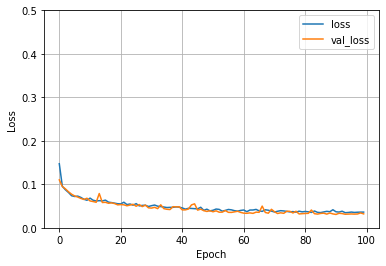

In [26]:
plot_loss(history_cu4_pos_drag_custom)

This loss looks so much higher than before. I wonder if the total work predictions are fixed/improved, though. FINGERS ARE CROSSED!

### Evaluate the performance of positive drag model WITH custom loss function

In [27]:
test_features_cu4_pos_drag = test_features_cu4_pos_drag[['x','eta','u','v']]
predicted_pos_drag_force_custom = dnn_model_cu4_pos_drag_custom.predict(test_features_cu4_pos_drag)

64/64 [==============================] - 0s 1ms/step


In [28]:
true_drag_force = cu4_drag_force[cu4_drag_force.index.isin(test_features_cu4_pos_drag.index)]['drag_force']
true_pos_drag_force = np.expand_dims(test_labels_cu4_pos_drag, axis=1)

test_features_cu4_pos_drag['dx'] = test_features_cu4_pos_drag['x'].diff()

# calculate the real work
products = test_features_cu4_pos_drag['dx'] * np.squeeze(true_drag_force)
products
real_work = np.sum(products)

# calculate the predicted work
products = test_features_cu4_pos_drag['dx'] * np.squeeze(predicted_pos_drag_force_custom)
predicted_work = np.sum(products)
predicted_work

# print the percent error
np.abs((predicted_work - real_work) / real_work) * 100

26.089729515373577

So if you just train while trying to minimize the total work difference, you can reduce the percent error to 23.9% (as compared to the 32% from before). This is significant. How does it affect the overall performance, though?

### Overall performance

From before, you have that the MAE is 1.439 (not bad).

In [29]:
np.sum(np.abs(true_pos_drag_force - predicted_pos_drag_force)) / len(predicted_pos_drag_force) 

1.43561310070868

Now, you have that the MAE is surprisingly close (1.506).

In [30]:
np.sum(np.abs(true_pos_drag_force - predicted_pos_drag_force_custom)) / len(predicted_pos_drag_force_custom) 

1.6057224828005785

What percent difference is this?

In [31]:
100 * np.abs(23.889033649774902 - 32.86807918307063) / 32.86807918307063

27.318437086888135

Therefore, you can reduce the total work error by about 27.3% without sacrificing the mean absolute error metric of the model (meaning that they should be pretty close in terms of prediction power).

### Drag force prediction visualization

In the previous notebook (total_work_comparisons_filtered_drag_models), we saw that the two DNNs (trained on positive and negative drag forces) had a lot of 0-value predictions for drag force. This is still the case, since the model is trained on a lot of zeroed-out datapoints.

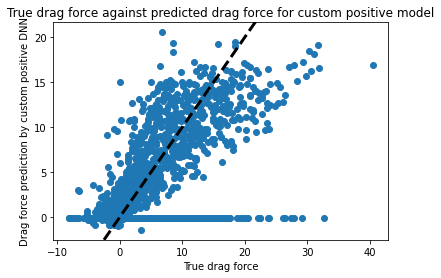

In [32]:
plt.scatter(true_drag_force, predicted_pos_drag_force_custom)
plt.title("True drag force against predicted drag force for custom positive model")
plt.xlabel("True drag force")
plt.ylabel("Drag force prediction by custom positive DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

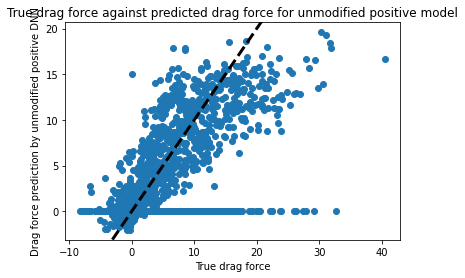

In [33]:
plt.scatter(true_drag_force, predicted_pos_drag_force)
plt.title("True drag force against predicted drag force for unmodified positive model")
plt.xlabel("True drag force")
plt.ylabel("Drag force prediction by unmodified positive DNN")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

We can compare the two model predictions side-by-side to see how they differ. In the custom positive drag force model, the total work is much more conserved. We already noted that this did not come at the expense of the mean absolute error of the model, so we don't actually expect these graphs to look very different from one another. In fact, they dont. Let's investigate a bit more to see if there are any notable differences, though.

Okay, correction. Look at the bottom left corner. It looks like the custom model is not predicting the negative drag forces that SHOULD be negative. It's making them positive (numerically, it's trying to increase that sum for total work without diverging too much from the actual drag force predictions). So it's ignoring the local physical truth for drag force predictions in favor of the global physical truth for total work.  

In [36]:
def distance(x,y):
    return np.abs(x - y) / math.sqrt(2)

In [104]:
total_distance = 0
index = 0

for i in true_drag_force.index:
    dist = distance(true_drag_force.at[i], np.squeeze(predicted_pos_drag_force_custom[index]))
    total_distance += dist
    index += 1

avg_distance = total_distance / len(true_drag_force)
avg_distance

2.9749272638466473

In [105]:
total_distance = 0
index = 0

for i in true_drag_force.index:
    dist = distance(true_drag_force.at[i], np.squeeze(predicted_pos_drag_force[index]))
    total_distance += dist
    index += 1

avg_distance = total_distance / len(true_drag_force)
avg_distance

2.864618104028566

We can see that the average distances, or the spread of the data around the y=x line, is more or less the same.